In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn import ensemble
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error
from numpy import absolute
from xgboost import plot_importance


### Read in the data

- timestamp - A timestamp for the minute covered by the row.
- Asset_ID - An ID code for the cryptoasset.
- Count - The number of trades that took place this minute.
- Open - The USD price at the beginning of the minute.
- High - The highest USD price during the minute.
- Low - The lowest USD price during the minute.
- Close - The USD price at the end of the minute.
- Volume - The number of cryptoasset units traded during the minute.
- VWAP - The volume weighted average price for the minute.
- Target - 15 minute residualized returns. 

In [2]:
crypto_df = pd.read_csv('csv/train.csv')
crypto_df.head(20)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7.0,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


In [3]:
asset_df = pd.read_csv('csv/asset_details.csv')
asset_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


### Clean the dataset

In [4]:
# check the datatypes and counts of each column
crypto_df.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   timestamp  24236806 non-null  int64  
 1   Asset_ID   24236806 non-null  int64  
 2   Count      24236806 non-null  float64
 3   Open       24236806 non-null  float64
 4   High       24236806 non-null  float64
 5   Low        24236806 non-null  float64
 6   Close      24236806 non-null  float64
 7   Volume     24236806 non-null  float64
 8   VWAP       24236797 non-null  float64
 9   Target     23486468 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [5]:
# double check the missing values in each column 
crypto_df.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [6]:
# replace NaN Values with Zeros in Target column
crypto_df["Target"] = crypto_df["Target"].fillna(0)
crypto_df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7.0,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,0.000000
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


In [7]:
# show all Rows with NaN Values in VWAP column
# from the output below we can see that all the nan values come from Asset_ID 10
crypto_df[crypto_df["VWAP"].isnull()]

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
15004269,1592173560,10,2.0,501.00,501.00,501.00,501.00,0.0,NaN,0.000000
15004283,1592173620,10,4.0,501.00,501.00,501.00,501.00,0.0,NaN,0.000000
15059232,1592426160,10,2.0,529.77,529.77,529.77,529.77,0.0,NaN,0.007356
15143187,1592823720,10,2.0,503.60,503.60,503.60,503.60,0.0,NaN,-0.005672
15183088,1593008940,10,2.0,484.16,484.16,484.16,484.16,0.0,NaN,-0.004281
15184216,1593013920,10,2.0,480.00,480.00,480.00,480.00,0.0,NaN,0.000000
15184243,1593014040,10,2.0,480.00,480.00,480.00,480.00,0.0,NaN,0.000000
15184309,1593014340,10,6.0,479.07,479.07,479.07,479.07,0.0,NaN,0.000000
15184778,1593016440,10,4.0,478.00,478.00,475.00,478.00,0.0,NaN,0.000000


In [8]:
# when I clean the data, I found a lot of gaps in data, which influence the consecutive of data visualisation 
# to fill the gaps, we can use the .reindex() method for forward filling, filling gaps with the previous valid value
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html

In [9]:
# I may code these following steps with function define later to fill gaps for each cryptocurrencies
# fill gaps for Bitcoin Cash
bit_cash = crypto_df[crypto_df["Asset_ID"]==2].set_index("timestamp")
bit_cash = bit_cash.reindex(range(bit_cash.index[0],bit_cash.index[-1]+60,60),method='pad')
(bit_cash.index[1:]-bit_cash.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [10]:
# fill gaps for Binance Coin
bin_coin = crypto_df[crypto_df["Asset_ID"]==0].set_index("timestamp")
bin_coin = bin_coin.reindex(range(bin_coin.index[0],bin_coin.index[-1]+60,60),method='pad')
(bin_coin.index[1:]-bin_coin.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [11]:
# fill gaps for Bitcoin 
bit = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp")
bit = bit.reindex(range(bit.index[0],bit.index[-1]+60,60),method='pad')
(bit.index[1:]-bit.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [12]:
# fill gaps for EOS.IO
eos = crypto_df[crypto_df["Asset_ID"]==5].set_index("timestamp")
eos = eos.reindex(range(eos.index[0],eos.index[-1]+60,60),method='pad')
(eos.index[1:]-eos.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [13]:
# fill gaps for Ethereum Classic
eth_classic = crypto_df[crypto_df["Asset_ID"]==7].set_index("timestamp")
eth_classic = eth_classic.reindex(range(eth_classic.index[0],eth_classic.index[-1]+60,60),method='pad')
(eth_classic.index[1:]-eth_classic.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [14]:
# fill gaps for Ethereum
eth = crypto_df[crypto_df["Asset_ID"]==6].set_index("timestamp")
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')
(eth.index[1:]-eth.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [15]:
# fill gaps for Litecoin
lite = crypto_df[crypto_df["Asset_ID"]==9].set_index("timestamp")
lite = lite.reindex(range(lite.index[0],lite.index[-1]+60,60),method='pad')
(lite.index[1:]-lite.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [16]:
# fill gaps for Monero
mon = crypto_df[crypto_df["Asset_ID"]==11].set_index("timestamp")
mon = mon.reindex(range(mon.index[0],mon.index[-1]+60,60),method='pad')
(mon.index[1:]-mon.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [17]:
### We find that the start dates of these 6 cryptocurrencies are not from the 2018-01-01, so we are not going to 
### include these in our project.
'''
tro = crypto_df[crypto_df["Asset_ID"]==13].set_index("timestamp")
tro = tro.reindex(range(tro.index[0],tro.index[-1]+60,60),method='pad')
(tro.index[1:]-tro.index[:-1]).value_counts()

ste = crypto_df[crypto_df["Asset_ID"]==12].set_index("timestamp")
ste = ste.reindex(range(ste.index[0],ste.index[-1]+60,60),method='pad')
(ste.index[1:]-ste.index[:-1]).value_counts()

car = crypto_df[crypto_df["Asset_ID"]==3].set_index("timestamp")
car = car.reindex(range(car.index[0],car.index[-1]+60,60),method='pad')
(car.index[1:]-car.index[:-1]).value_counts()

iota = crypto_df[crypto_df["Asset_ID"]==8].set_index("timestamp")
iota = iota.reindex(range(iota.index[0],iota.index[-1]+60,60),method='pad')
(iota.index[1:]-iota.index[:-1]).value_counts()

mak = crypto_df[crypto_df["Asset_ID"]==10].set_index("timestamp")
mak = mak.reindex(range(mak.index[0],mak.index[-1]+60,60),method='pad')
(mak.index[1:]-mak.index[:-1]).value_counts()

dog = crypto_df[crypto_df["Asset_ID"]==4].set_index("timestamp")
dog = dog.reindex(range(dog.index[0],dog.index[-1]+60,60),method='pad')
(dog.index[1:]-dog.index[:-1]).value_counts()
'''

'\ntro = crypto_df[crypto_df["Asset_ID"]==13].set_index("timestamp")\ntro = tro.reindex(range(tro.index[0],tro.index[-1]+60,60),method=\'pad\')\n(tro.index[1:]-tro.index[:-1]).value_counts()\n\nste = crypto_df[crypto_df["Asset_ID"]==12].set_index("timestamp")\nste = ste.reindex(range(ste.index[0],ste.index[-1]+60,60),method=\'pad\')\n(ste.index[1:]-ste.index[:-1]).value_counts()\n\ncar = crypto_df[crypto_df["Asset_ID"]==3].set_index("timestamp")\ncar = car.reindex(range(car.index[0],car.index[-1]+60,60),method=\'pad\')\n(car.index[1:]-car.index[:-1]).value_counts()\n\niota = crypto_df[crypto_df["Asset_ID"]==8].set_index("timestamp")\niota = iota.reindex(range(iota.index[0],iota.index[-1]+60,60),method=\'pad\')\n(iota.index[1:]-iota.index[:-1]).value_counts()\n\nmak = crypto_df[crypto_df["Asset_ID"]==10].set_index("timestamp")\nmak = mak.reindex(range(mak.index[0],mak.index[-1]+60,60),method=\'pad\')\n(mak.index[1:]-mak.index[:-1]).value_counts()\n\ndog = crypto_df[crypto_df["Asset_ID"]

In [18]:
# check again to see if there still any missing data left

#frames = [bit_cash, bin_coin, bit, eos, eth_classic, eth, lite, mon]
bit_cash.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [19]:
bin_coin.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [20]:
bit.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [21]:
eos.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [22]:
eth_classic.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [23]:
eth.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [24]:
lite.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [25]:
mon.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

### Split training and testing data for each cryptocurrency
We'll select 6 of the most popular cryptocurrencies to feed in the machine learning model for the prediction.
Crypto list for analysing: Binance Coin, Bitcoin, EOS.IO, Ethereum, Litecoin, Monero.

In [26]:
# add some new relevent features in the dataset
def add_features(df):
    #df['Upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    #df['Lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    df["log_return"] = np.log(df['VWAP']).diff(periods=15)
    return df

df_list = [bin_coin, bit, eos, eth, lite, mon]
for df in df_list:
    df = add_features(df)

In [27]:
bin_coin.head(20)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_return
timestamp,,,,,,,,,,
1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399,NaN
1514764920,0,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875,NaN
1514764980,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410,NaN
1514765040,0,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524,NaN
1514765100,0,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940,NaN
1514765160,0,89.0,8.4560,8.4560,8.3999,8.4000,3765.25,8.403468,-0.005455,NaN
1514765220,0,20.0,8.4000,8.4000,8.3800,8.3958,827.17,8.390564,-0.000644,NaN
1514765280,0,25.0,8.3800,8.4544,8.3800,8.3804,370.04,8.390332,-0.003580,NaN
1514765340,0,16.0,8.3999,8.4519,8.3800,8.3800,1428.91,8.400632,-0.005421,NaN


In [28]:
# check time point
print(datetime.utcfromtimestamp(bin_coin.index[1824480]))

2021-06-21 00:01:00


  # XGBooster for Regression  

 
Perhaps the most commonly configured hyperparameters are the following:

### n_estimators:
The number of trees in the ensemble, often increased until no further improvements are seen.

### max_depth: 
The maximum depth of each tree, often values are between 1 and 10.

### eta: 
The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.

### subsample:
The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.

### colsample_bytree:
Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [29]:
# Split training and testing data for Binance Coin
bin_coin_train = bin_coin[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
bin_coin_test = bin_coin[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_bin_coin_train = bin_coin_train.log_return.values.reshape(-1, 1)
X_bin_coin_test = bin_coin_test.log_return.values.reshape(-1, 1)
y_bin_coin_train = bin_coin_train.Target
y_bin_coin_test = bin_coin_test.Target

In [30]:
# create an xgboost regression model
model = XGBRegressor()

In [31]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cv

RepeatedKFold(n_repeats=3, n_splits=10, random_state=1)

In [32]:
model.fit(X_bin_coin_train, y_bin_coin_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [33]:
score = model.score(X_bin_coin_train, y_bin_coin_train)  
print("Training score: ", score)

Training score:  0.04470808267906512


In [34]:
scores = cross_val_score(model, X_bin_coin_train,y_bin_coin_train,cv=10)
print("Mean cross-validation score: %.4f" % scores.mean())

Mean cross-validation score: -0.0157


In [35]:
ypred = model.predict(X_bin_coin_test)
mse = mean_squared_error(y_bin_coin_test, ypred)
print("MSE: % .4f" % mse)
print("RMSE: % .4f" % (mse**(1/2.0)))

MSE:  0.0000
RMSE:  0.0027


In [36]:
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.4f (%.4f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.0157 (0.0256)


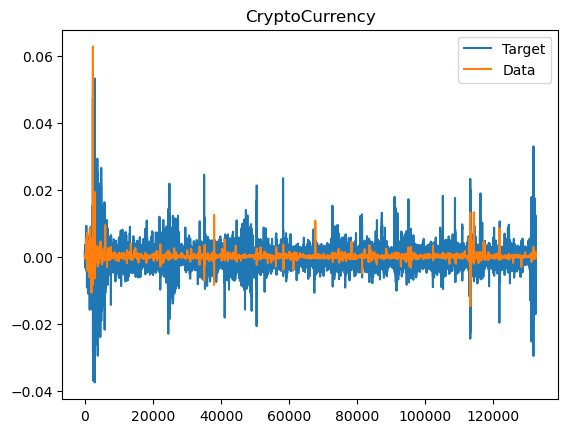

In [37]:
x_ax = range(len(y_bin_coin_test))
plt.plot(x_ax, y_bin_coin_test, label="Target")
plt.plot(x_ax, ypred, label="Data")
plt.title("CryptoCurrency")
plt.legend()
plt.show()

In [38]:
# Split training and testing data for Bitcoin
bit_train = bit[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
bit_test = bit[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_bit_train = bit_train.log_return.values.reshape(-1, 1)
X_bit_test = bit_test.log_return.values.reshape(-1, 1)
y_bit_train = bit_train.Target
y_bit_test = bit_test.Target

In [39]:
# create an xgboost regression model
model = XGBRegressor()

In [40]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cv

RepeatedKFold(n_repeats=3, n_splits=10, random_state=1)

In [41]:
model.fit(X_bit_train, y_bit_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [42]:
score = model.score(X_bit_train, y_bit_train)  
print("Training score: ", score)

Training score:  0.05473592597160171


In [43]:
scores = cross_val_score(model, X_bit_train, y_bit_train,cv=10)
print("Mean cross-validation score: %.4f" % scores.mean())

Mean cross-validation score: -0.0250


In [44]:
ypred = model.predict(X_bit_test)
mse = mean_squared_error(y_bit_test, ypred)
print("MSE: % .4f" % mse)
print("RMSE: % .4f" % (mse**(1/2.0)))

MSE:  0.0000
RMSE:  0.0016


In [45]:
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.4f (%.4f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.0250 (0.0271)


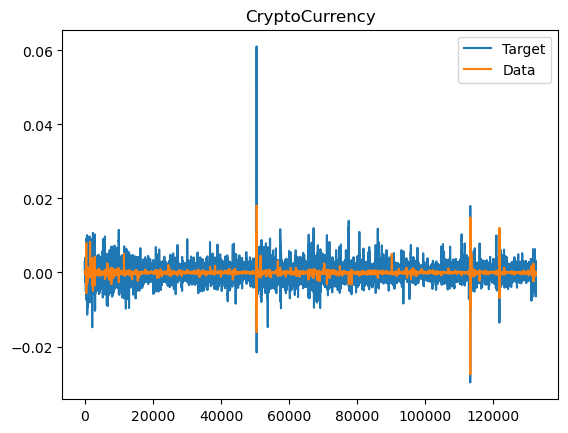

In [46]:
x_ax = range(len(y_bit_test))
plt.plot(x_ax, y_bit_test, label="Target")
plt.plot(x_ax, ypred, label="Data")
plt.title("CryptoCurrency")
plt.legend()
plt.show()

In [47]:
# Split training and testing data for EOS.IO
eos_train = eos[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
eos_test = eos[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_eos_train = eos_train.log_return.values.reshape(-1, 1)
X_eos_test = eos_test.log_return.values.reshape(-1, 1)
y_eos_train = eos_train.Target
y_eos_test = eos_test.Target

In [48]:
# create an xgboost regression model
model = XGBRegressor()

In [49]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cv

RepeatedKFold(n_repeats=3, n_splits=10, random_state=1)

In [50]:
model.fit(X_eos_train, y_eos_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [51]:
score = model.score(X_eos_train, y_eos_train)  
print("Training score: ", score)

Training score:  0.06313246154817986


In [52]:
scores = cross_val_score(model, X_eos_train, y_eos_train,cv=10)
print("Mean cross-validation score: %.4f" % scores.mean())

Mean cross-validation score: -0.0146


In [53]:
ypred = model.predict(X_eos_test)
mse = mean_squared_error(y_eos_test, ypred)
print("MSE: %.4f" % mse)
print("RMSE: %.4f" % (mse**(1/2.0)))

MSE: 0.0000
RMSE: 0.0030


In [54]:
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.4f (%.4f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.0152 (0.0145)


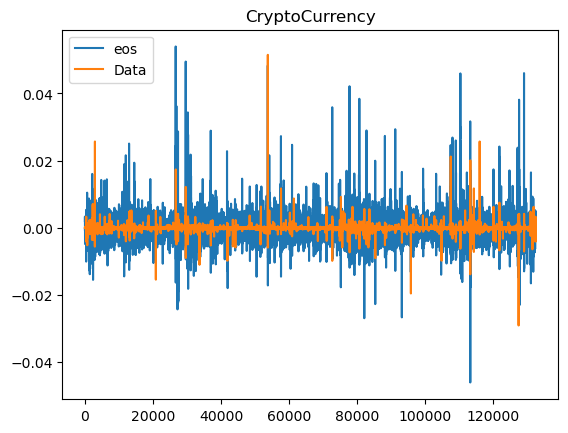

In [55]:
x_ax = range(len(y_eos_test))
plt.plot(x_ax, y_eos_test, label="eos")
plt.plot(x_ax, ypred, label="Data")
plt.title("CryptoCurrency")
plt.legend()
plt.show()

In [56]:
# Split training and testing data for Ethereum
eth_train = eth[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
eth_test = eth[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_eth_train = eth_train.log_return.values.reshape(-1, 1)
X_eth_test = eth_test.log_return.values.reshape(-1, 1)
y_eth_train = eth_train.Target
y_eth_test = eth_test.Target

In [57]:
# create an xgboost regression model
model = XGBRegressor()

In [58]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cv

RepeatedKFold(n_repeats=3, n_splits=10, random_state=1)

In [59]:
model.fit(X_eth_train, y_eth_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [60]:
score = model.score(X_eth_train, y_eth_train)  
print("Training score: ", score)

Training score:  0.03839483095298413


In [61]:
scores = cross_val_score(model, X_eth_train, y_eth_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: -0.01


In [62]:
ypred = model.predict(X_eth_test)
mse = mean_squared_error(y_eth_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 0.00
RMSE: 0.00


In [63]:
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.011 (0.011)


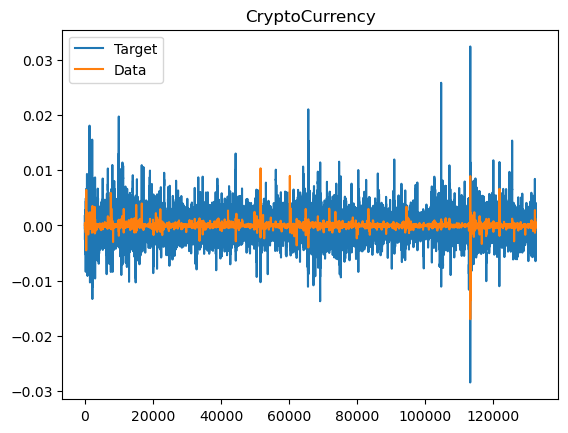

In [64]:
x_ax = range(len(y_eth_test))
plt.plot(x_ax, y_eth_test, label="Target")
plt.plot(x_ax, ypred, label="Data")
plt.title("CryptoCurrency")
plt.legend()
plt.show()

In [65]:
# Split training and testing data for Litecoin
lite_train = lite[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
lite_test = lite[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_lite_train = lite_train.log_return.values.reshape(-1, 1)
X_lite_test = lite_test.log_return.values.reshape(-1, 1)
y_lite_train = lite_train.Target
y_lite_test = lite_test.Target

In [66]:
# create an xgboost regression model
model = XGBRegressor()

In [67]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cv


RepeatedKFold(n_repeats=3, n_splits=10, random_state=1)

In [68]:
model.fit(X_lite_train , y_lite_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [69]:
score = model.score(X_lite_train, y_lite_train)  
print("Training score: ", score)

Training score:  0.044029217853942204


In [70]:
scores = cross_val_score(model, X_lite_train, y_lite_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: -0.02


In [71]:
ypred = model.predict(X_lite_test)
mse = mean_squared_error(y_lite_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 0.00
RMSE: 0.00


In [72]:
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.015 (0.011)


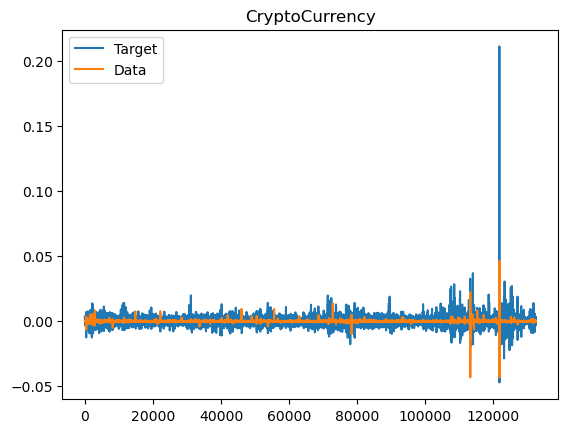

In [73]:
x_ax = range(len(y_lite_test))
plt.plot(x_ax, y_lite_test, label="Target")
plt.plot(x_ax, ypred, label="Data")
plt.title("CryptoCurrency")
plt.legend()
plt.show()

In [74]:
# Split training and testing data for Monero
mon_train = mon[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
mon_test = mon[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_mon_train = mon_train.log_return.values.reshape(-1, 1)
X_mon_test = mon_test.log_return.values.reshape(-1, 1)
y_mon_train = mon_train.Target
y_mon_test = mon_test.Target

In [75]:
# create an xgboost regression model
model = XGBRegressor()

In [76]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cv

RepeatedKFold(n_repeats=3, n_splits=10, random_state=1)

In [77]:
model.fit(X_mon_train, y_mon_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [78]:
score = model.score(X_mon_train, y_mon_train)  
print("Training score: ", score)

Training score:  0.037651207935959


In [79]:
scores = cross_val_score(model, X_mon_train, y_mon_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: -0.02


In [80]:
ypred = model.predict(X_mon_test)
mse = mean_squared_error(y_mon_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 0.00
RMSE: 0.00


In [81]:
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.018 (0.027)


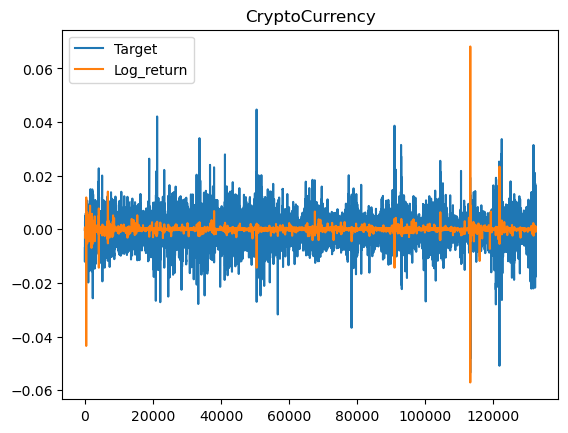

In [82]:
x_ax = range(len(y_mon_test))
plt.plot(x_ax, y_mon_test, label="Target")
plt.plot(x_ax, ypred, label="Log_return")
plt.title("CryptoCurrency")
plt.legend()
plt.show()

In [117]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance

<function matplotlib.pyplot.show(close=None, block=None)>

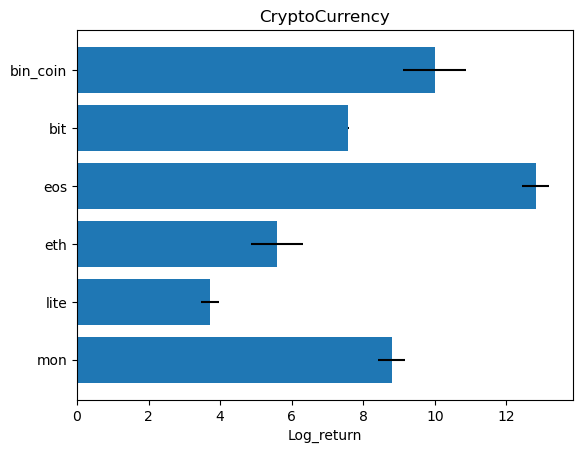

In [143]:
# Display features 'importance of the model'

np.random.seed(1956959)

plt.rcdefaults()
fig, ax = plt.subplots()

coins= ('bin_coin', 'bit', 'eos', 'eth', 'lite', 'mon' )
y_pos = np.arange(len(coins))
performance = 3 + 10 * np.random.rand(len(coins))
error = np.random.rand(len(coins))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos, labels=coins)
ax.invert_yaxis()
ax.set_xlabel('Log_return')
ax.set_title('CryptoCurrency')

plt.show

### Scale the traning and testing data

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Scale the data for those six cryptocurrencies
X_bin_coin_train_scaled = scaler.fit_transform(X_bin_coin_train)
X_bin_coin_test_scaled = scaler.fit_transform(X_bin_coin_test)

X_bit_train_scaled = scaler.fit_transform(X_bit_train)
X_bit_test_scaled = scaler.fit_transform(X_bit_test)

X_eos_train_scaled = scaler.fit_transform(X_eos_train)
X_eos_test_scaled = scaler.fit_transform(X_eos_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.fit_transform(X_eth_test)

X_lite_train_scaled = scaler.fit_transform(X_lite_train)
X_lite_test_scaled = scaler.fit_transform(X_lite_test)

X_mon_train_scaled = scaler.fit_transform(X_mon_train)
X_mon_test_scaled = scaler.fit_transform(X_mon_test)

### Merge the dataset for Tableau visualisation

In [ ]:
# merge all the dataset together
# refer: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames = [bin_coin, eos, bit, eth, lite, mon]
crypto_con_df = pd.concat(frames)
crypto_con_df.head()

In [ ]:
# use the timestamp index to sort the values
crypto_con_df = crypto_con_df.sort_index()
crypto_con_df.head(10)

In [ ]:
crypto_con_df.index[7793280].astype('datetime64[s]')

In [ ]:
crypto_con_df = crypto_con_df.iloc[7793280:]
crypto_con_df.head(10)

In [ ]:
print(datetime.utcfromtimestamp(1592697660))

In [ ]:
# Convert Index to Column
crypto_con_df.reset_index(inplace=True)
crypto_con_df.head()

In [ ]:
# convert the timestamp
crypto_con_df["date"]=pd.to_datetime(crypto_con_df["timestamp"], unit='s')
crypto_con_df.head()

In [ ]:
# check the datatypes of all the columns 
crypto_con_df.info(show_counts =True)

In [ ]:
# merge crypto_con_df with DataFrame contains asset details
crypto_details_df = pd.merge(crypto_con_df, asset_df, how="left", on=["Asset_ID", "Asset_ID"])
crypto_details_df.head()

In [ ]:
# re-order the columns name
new_column_order = ["timestamp","date","Asset_ID","Asset_Name","Weight","Count","Volume","Open","High","Low","Close","VWAP","Target"]
crypto_details_df = crypto_details_df[new_column_order]
crypto_details_df.head(10)

In [ ]:
# export data into a CSV
output_data_file = "csv/crypto_details_target.csv"
crypto_details_df.to_csv(output_data_file)

### Create machine learning model

In [ ]:
# Train the data using LinearRegression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_bin_coin_train_scaled,y_bin_coin_train)
y_pred_bin_coin = lr.predict(X_bin_coin_test_scaled)

lr.fit(X_eos_train_scaled,y_eos_train)
y_pred_eos = lr.predict(X_eos_test_scaled)

lr.fit(X_bit_train_scaled,y_bit_train)
y_pred_bit = lr.predict(X_bit_test_scaled)

lr.fit(X_eth_train_scaled,y_eth_train)
y_pred_eth = lr.predict(X_eth_test_scaled)

lr.fit(X_lite_train_scaled,y_lite_train)
y_pred_lite = lr.predict(X_lite_test_scaled)

lr.fit(X_mon_train_scaled,y_mon_train)
y_pred_mon = lr.predict(X_mon_test_scaled)

In [ ]:
#from sklearn.metrics import mean_squared_error
#np.sqrt(mean_squared_error(y_bin_coin_test, y_pred_bin_coin))

In [ ]:
print(f"Test score for bin_coin: {np.corrcoef(y_bin_coin_test, y_pred_bin_coin)[1,0]:.4f}")
print(f"Test score for eos: {np.corrcoef(y_eos_test, y_pred_eos)[1,0]:.4f}")
print(f"Test score for bit: {np.corrcoef(y_bit_test, y_pred_bit)[1,0]:.4f}")
print(f"Test score for eth: {np.corrcoef(y_eth_test, y_pred_eth)[1,0]:.4f}")
print(f"Test score for lite: {np.corrcoef(y_lite_test, y_pred_lite)[1,0]:.4f}")
print(f"Test score for mon: {np.corrcoef(y_mon_test, y_pred_mon)[1,0]:.4f}")

### Data visualisation

In [ ]:
# visualize the target of each cryptocurrencies
plt.figure(figsize=(15,6))

plt.plot(bin_coin['Target'], label='bin_coin', color="blue")
plt.plot(bit['Target'], label='bit', color="green")
plt.plot(eos['Target'], label='eos', color="yellow")
plt.plot(eth['Target'], label='eth', color="red")

plt.legend()
plt.xlabel('Time')
plt.ylabel('Target')

plt.tight_layout()
plt.show()

In [ ]:
# visualize the close price of each cryptocurrencies
plt.figure(figsize=(15,6))

plt.plot(bin_coin['Close'], label='bin_coin', color="blue")
plt.plot(bit['Close'], label='bit', color="green")
plt.plot(eos['Close'], label='eos', color="yellow")
plt.plot(eth['Close'], label='eth', color="black")

plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()

In [ ]:
# above just some examples, create any plots which you think is good

# YOUR CODE HERE

### Connect to SQL Database

In [ ]:
# Connect to SQL Database

# YOUR CODE HERE